In [19]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.family'] = 'STIXGeneral'  # Closely matches Computer Modern
plt.rcParams['mathtext.fontset'] = 'stix'    # Use STIX for math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Load the CSV file into a DataFrame
# Replace 'path/to/your.csv' with the actual file path
df = pd.read_csv('~/Downloads/table2_extended.csv')

# Display the first few rows to verify
df.head()

,Name,Rank,D (Mpc),Survey,log Mbh,log h_0,LDA,h norm,LDA norm,Total score,Profile chosen,RA (deg),Dec (deg)
0,NGC4073,1,91.5,MASSIVE,10.25,-13.04,4.08,0.98,0.99,0.99,C,181.112800,1.8960
1,NGC1016,2,95.2,MASSIVE,10.25,-13.06,3.86,0.98,0.97,0.97,C,39.581500,2.1193
2,NGC2832,3,105.2,MASSIVE,10.30,-13.02,3.62,0.99,0.94,0.97,C,139.945300,33.7498
3,NGC4486,4,17.2,ATLAS3D,9.72,-13.20,4.03,0.93,0.98,0.96,C,187.705933,12.3911
4,NGC1060,5,67.4,MASSIVE,10.00,-13.32,4.21,0.90,1.00,0.95,NaN,40.812700,32.4250


In [8]:
# Extract the desired columns and rename them
df_extracted = df[['Rank', 'log Mbh', 'D (Mpc)']].rename(
    columns={'log Mbh': 'logMbh', 'D (Mpc)': 'D'}
)

# Display the result
df_extracted.head()

,Rank,logMbh,D
0,1,10.25,91.5
1,2,10.25,95.2
2,3,10.30,105.2
3,4,9.72,17.2
4,5,10.00,67.4


In [9]:
import numpy as np

# Constants
G    = 6.67430e-11           # gravitational constant [m^3 kg^-1 s^-2]
M_sun = 1.98847e30           # solar mass [kg]
pc   = 3.085677581491367e16  # parsec [m]
Mpc  = pc * 1e6              # megaparsec [m]
f_gw = 1e-8                  # GW frequency [Hz] (10 nHz)

# Total mass in kg (assuming M_tot = 10**logMbh * M_sun)
M_tot = 10**df_extracted['logMbh'] * M_sun

# Orbital separation a (m), from  f_gw = (1/π)·√(G M_tot / a^3)
a = (G * M_tot / (np.pi**2 * f_gw**2))**(1/3)

# Angular separation θ = a / D  (radians)
theta_rad = a / (df_extracted['D'] * Mpc)

# Convert to arcseconds
theta_arcsec = theta_rad * (180/np.pi) * 3600

# Attach to dataframe
df_extracted['a_m']         = a
df_extracted['theta_arcsec'] = theta_arcsec

# Inspect the first few results
df_extracted[['Rank','logMbh','D','a_m','theta_arcsec']].head()

,Rank,logMbh,D,a_m,theta_arcsec
0,1,10.25,91.5,1.337237e+15,0.000098
1,2,10.25,95.2,1.337237e+15,0.000094
2,3,10.30,105.2,1.389553e+15,0.000088
3,4,9.72,17.2,8.903109e+14,0.000346
4,5,10.00,67.4,1.103761e+15,0.000109


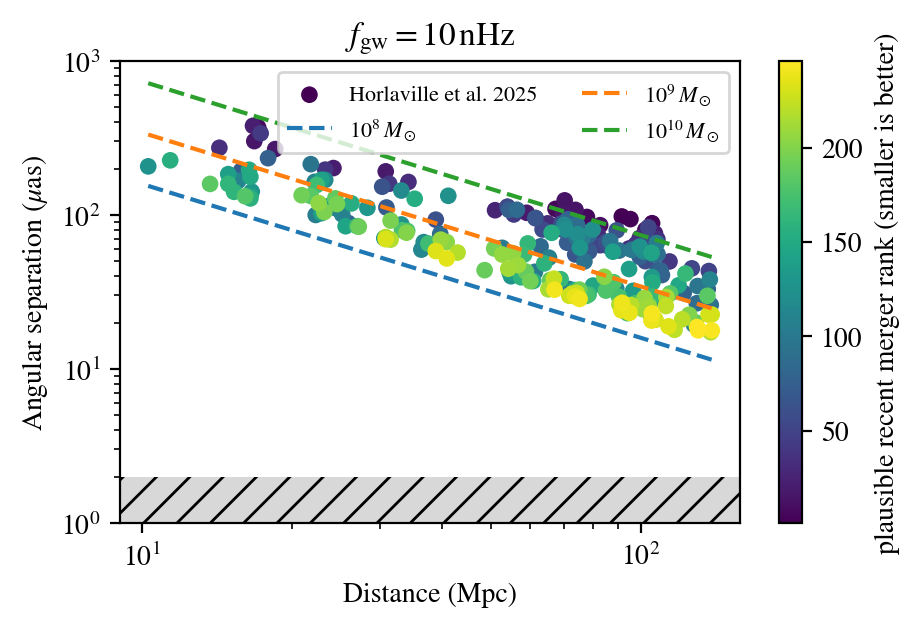

In [34]:
sc = plt.scatter(
    df_extracted['D'],
    df_extracted['theta_arcsec'] / 1e-6,
    c=df_extracted['Rank'],
    cmap='viridis',
    edgecolors='none', label='Horlaville et al. 2025'
)
plt.xscale('log')
plt.yscale('log')

# add a gray, hatched region from y=1 up to y=2 μas
plt.axhspan(1.0, 2.0, facecolor='gray', alpha=0.3, hatch='//')

plt.ylim(1.0, 1e3)
plt.xlabel('Distance (Mpc)')
plt.ylabel('Angular separation ($\mu$as)')
plt.colorbar(sc, label='plausible recent merger rank (smaller is better)')

# add constant-mass lines for 1e7–1e10 M⊙
D_vals = np.logspace(
    np.log10(df_extracted['D'].min()),
    np.log10(df_extracted['D'].max()),
    200
)

labs = ['$10^8\,M_\\odot$', '$10^9\,M_\\odot$', '$10^{10}\,M_\\odot$']
for ii,M in enumerate([1e8, 1e9, 1e10]):
    a_const = (G * M * M_sun / (np.pi**2 * f_gw**2))**(1/3)
    # θ in μas
    theta_const = (a_const / (D_vals * Mpc)) * (180/np.pi) * 3600 * 1e6
    plt.plot(D_vals, theta_const, '--', label=labs[ii])

plt.legend(ncols=2, loc='upper right', fontsize=8)
plt.title('$f_\mathrm{gw}=10\,\mathrm{nHz}$')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(5., 3.)

plt.show()
